# Analysis Of Binghamton University's Men's Ultimate Frisbee Statisics


During this project, I recreated and improved the statistics application *UltiAnalytics*. Paired with a mobile, device, *UltiAnalytics* compiles a multitude of individual and team statistics. Raw statistics are first taken from a mobile device and then transferred to *UltiAnalyticss* main site. There, it is compiled and displayed in a graphical user interface. Features include filtering by game, seeing a flow chart of passes, and computing team statistics. A reference can be viewed [here](https://www.ultianalytics.com/app/index.html#/5781282907750400/players?game-0cc51f7d-2792-4fee-b4f8-24fe529675af).  


The raw data from this site is able to be downloaded. It must be proccsed and interpetted in order to formulate statistics. Many of the basic stats such as assists, goals, catches, drops and more were done in the same manner as the site. Some statiscs, however, like plusMinus, assistsToAssists, and chanceOfScoring were created in hope of finding a deeper understanding of positively and negatively contributing players. Additionally, a correlation between pullHangTime and aquiring a D on the same point was researched. All of these analytics were developed in hope to gather a better understading at the following questions: 

* How valuable is a player? 
* Does a good pull really increase your chance of getting a D? 
* Can you find a correlation between offensive and defense productively just by looking at their presense on the field?



### Compile and process data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from Player import *
from Main import processActions

pd.set_option('display.precision', 2)
pd.set_option('display.max_columns', None)
df = pd.read_csv('BigBearStats.csv', index_col=2)
badColumns = ['Date/Time', 'Point Elapsed Seconds','Player 7', 'Player 8', 
           'Player 9', 'Player 10', 'Player 11', 'Player 12', 'Player 13', 'Player 14', 
           'Player 15', 'Player 16', 'Player 17', 'Player 18', 'Player 19', 'Player 20', 
           'Player 21', 'Player 22', 'Player 23', 'Player 24', 'Player 25', 'Player 26', 
           'Player 27', 'Elapsed Time (secs)', 'Begin X', 'Begin Y', 'End X', 'End Y', 
           'Distance Unit of Measure', 'Absolute Distance', 'Lateral Distance', 'Toward Our Goal Distance', 'Begin Area', 'End Area']
def getPlayers(df):
    players = {}
    playerColNames = ['Player 0', 'Player 1', 'Player 2', 'Player 3', 'Player 4', 'Player 5', 'Player 6']
    for col in playerColNames:
        for playerName in df[col]:
            curPlayer = Player(playerName)
            players.update({playerName: curPlayer})
    return players
df = df.drop(badColumns, axis=1)
players = getPlayers(df) 
playersDF = pd.DataFrame.from_records((vars(player) for player in list(players.values())), index='name')
df = df.rename(columns={'Tournamemnt': 'Tournament'})
players, pullsHangTime = processActions(df, players)
playersDF = pd.DataFrame.from_records((vars(player) for player in list(players.values())), index='name')
playersDF.drop(['pointsWhenPlaying', 'opsToScore', 'games','numGamesPlayed', 'pulls'], axis=1, inplace=True)


### How Data is Processed

Many classes were created for this project. A Main, Player, Game, and Test classes were all created in the hope of ogranizing the code. Each participant has an attached Player class that is pointed to by the players dictionary. Each Player has statistical attributes such as goals, points played, etc. All of these attributes are also abstracted out to individual games attached to each Player. Hence, each Players have a collection of Game objects in which the same attributes, assists, goals, points played, etc, are stored. 

The raw data is proccessed through the ProcessActions function in the Main class: 

```python
def getAttributes(curAction):
    activePlayers = []
    name = curAction.name
    game = (curAction['Tournament'], curAction.name)
    line = curAction['Line']
    eventType = curAction['Event Type']
    action = curAction['Action']
    passer = curAction['Passer']   
    receiver = curAction['Receiver']   
    defender = curAction['Defender']   
    hangTime = curAction['Hang Time (secs)']   
    activePlayers.append(curAction['Player 0'])
    activePlayers.append(curAction['Player 2'])
    activePlayers.append(curAction['Player 2'])
    activePlayers.append(curAction['Player 3'])
    activePlayers.append(curAction['Player 4'])
    activePlayers.append(curAction['Player 5'])
    activePlayers.append(curAction['Player 6'])  
    ourScoreEOP = curAction['Our Score - End of Point']
    theirScoreEOP = curAction['Their Score - End of Point']
    return (name, game, line, eventType, action, passer, receiver, defender, hangTime, activePlayers, ourScoreEOP, theirScoreEOP)  
def processActions(df, players):
    curOpponent = ''
    ourScore = 0
    theirScore = 0
    startingEventType = ''
    pullHangtime = {}
    activePull = False
    activePullTime = 0.0
    prevPasser = 'Anonymous'
    for row in range(len(df)):
        curAction = df.iloc[row]
        name, game, line, eventType, action, passer, receiver, defender, hangTime, activePlayers, ourScoreEOP, theirScoreEOP = getAttributes(df.iloc[row])
        if startingEventType != eventType: 
            startingEventType = eventType
            if startingEventType == 'Offense':
              for player in activePlayers:
                players[player].incrOpsToScore()
        if name != curOpponent: ## new game
            curOpponent = name         
            ourScore = 0
            theirScore = 0
            startingEventType = eventType
        if ourScoreEOP != ourScore: ## after this action, we scored
            ourScore = ourScoreEOP
            activePull = False
            players = incrementPointsPlayed(curAction, players)
        elif theirScoreEOP != theirScore: ## after this action they score
            players = incrementPointsPlayed(curAction, players)
            theirScore = theirScoreEOP
            activePull = False
        if defender != 'Anonymous':
            if action == 'Pull':
                players[defender].incrPulls(hangTime, game)
                activePullTime = hangTime
                pullHangtime[activePullTime] = False
                activePull = True
            elif action == 'PullOb':
                players[defender].incrPulls(0.0, game)
        if eventType == 'Offense':
            if action == 'Goal':
                players[passer].incrAssists(game)
                players[receiver].incrGoals(game)
                players[receiver].incrCatches(game)
                players[receiver].changePM(game, 1.0) ## They score, PM + 1
                players[passer].changePM(game, 0.8) ## They assist, PM + 0.8
                players[passer].changeOGPM(game, 1)
                players[receiver].changeOGPM(game, 1)
                for player in activePlayers: 
                    players[player].incrPointsWhenPlaying()
                    players[player].changePM(game, 0.15) ## They are on the field when we score, PM + 0.15
                if passer != 'Anonymous':
                    players[passer].incrCmpltn(game)
                if prevPasser != 'Anonymous':
                    players[prevPasser].incrATOA(game)
                    players[player].changePM(game, 0.33) ## Assist To Assist, PM +0.05
            elif action == 'Catch':
                players[receiver].incrCatches(game)
                prevPasser = passer
                if passer != 'Anonymous':
                    players[passer].incrCmpltn(game)
            elif action == 'Throwaway' and passer != 'Anonymous':
                players[passer].incrThrowaways(game)
                players[passer].changePM(game, -0.9)
                players[passer].changeOGPM(game, -1)
                for player in activePlayers: 
                    players[player].changePM(game, -0.1)
            elif action == 'Drop':
                players[receiver].incrDrops(game)
                players[receiver].changePM(game, -0.75)
                players[receiver].changeOGPM(game, -1)
                for player in activePlayers:
                    players[player].changePM(game, -0.05)
            elif action == 'Stall':
                players[passer].changePM(game, -1.0)
                players[passer].changeOGPM(game, -1)
        if eventType == 'Defense':
            if action == 'D' or action == 'Throwaway':
                if activePull:
                    pullHangtime[activePullTime] = True
                    activePull = False
                if action == 'D' and defender != 'Anonymous':
                    players[defender].incrDs(game)
                    players[defender].changePM(game, 0.9)
                    players[defender].changeOGPM(game, 1)
                    for player in activePlayers:
                        players[player].changePM(game, 0.05)
            elif action == 'Callahan':
                players[defender].changePM(game, 2)
                players[defender].changeOGPM(game, 2)
                for player in activePlayers:
                        players[player].changePM(game, 0.05)
    return (players, pullHangtime)
```

Unit tests were also setup in the Test.py file. These tests were created to ensure correct statistcal calculation as the algorthim was created. The correct test data was taken from the [UltiAnalytics](https://www.ultianalytics.com/app/index.html#/5781282907750400/players?game-0cc51f7d-2792-4fee-b4f8-24fe529675af) page. 

### Dataframe showing computated data

In [2]:
playersDF

,pointsPlayed,goals,assists,assistsToAssists,catches,ogPlusMinus,plusMinus,throwaways,drops,ds,completions,obPulls,avgPullHangtime,passingPercent,catchingPercent,chanceOfScoring
name,,,,,,,,,,,,,,,,
Blaze,76,9,10,5,93,10,10.65,14,4,9,72,0,5.75,0.84,24.25,0.36
Ty,73,5,0,1,16,7,7.70,2,1,5,10,0,4.12,0.83,17.00,0.36
Chris,88,5,5,3,55,4,5.30,9,2,5,52,0,0.00,0.85,28.50,0.33
Billy,67,2,10,9,133,1,0.15,11,2,2,173,0,4.51,0.94,67.50,0.32
Lebron,69,4,0,0,9,7,8.00,1,0,4,4,0,0.00,0.80,0.00,0.36
Ian,68,3,9,4,63,11,10.85,8,0,7,65,2,5.27,0.89,0.00,0.40
Matt,21,2,1,0,10,-1,-0.95,2,2,0,5,0,0.00,0.71,6.00,0.25
C^2,62,4,2,1,25,7,5.55,2,0,3,18,0,0.00,0.90,0.00,0.27
Ryan,4,0,1,0,5,2,1.60,0,0,1,5,0,0.00,0.00,0.00,0.25


### Redesigned Plus Minus

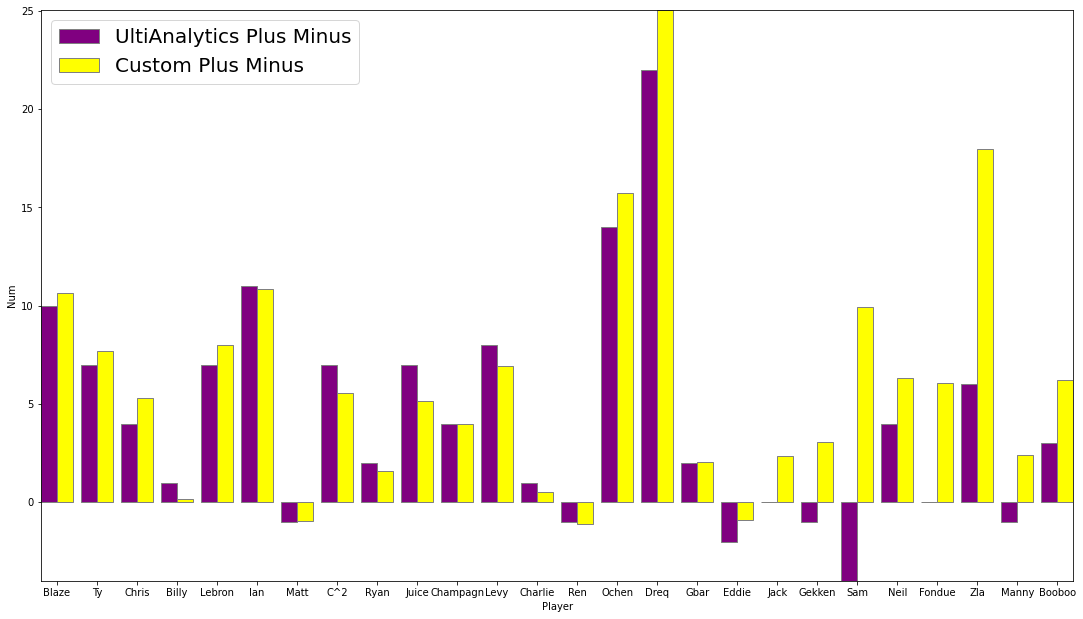

In [3]:

ogPM = playersDF.loc[:,'ogPlusMinus']
plusMinus = playersDF.loc[:,'plusMinus']
width = 0.4
plt.bar(np.arange(len(ogPM)), ogPM, color='purple', width=width, edgecolor='grey', label='UltiAnalytics Plus Minus')
plt.bar(np.arange(len(plusMinus)) + width, plusMinus, color='yellow', width=width, edgecolor='grey', label='Custom Plus Minus')
plt.xlabel('Player')
plt.ylabel('Num')
plt.legend(loc=2, prop={'size': 20})
plt.xticks(np.arange(len(ogPM)) + width/2, playersDF.index)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.margins(0)
plt.show()





The above graph compares the plus minus as calculated on *UltiAnalytics* and a newly formulated plus minus. The hope of this new plus minus is to give more weight to players being on a line in which a positive or negative action occurs. The differences are described below: 

Original Plus Minus: 
* +1: goal, assist, or D 
* -1: drop or thrown turnover
* +2: callahan

New Plus Minus: 
* +2: callahan
* +1: goal
* +0.8: assist
* +0.15: being on the field when a goal occurs
* +0.33: assist to assist thrown
* +0.9: D
* +0.05: on the field when a D  or callahan occurs
* -0.9: throwaway
* -0.1: throaway occurs when on the field
* -0.75: drop 
* -0.05: on the field when a drop occurs
* -1: stalled out

### Implementation of Hockey Assists

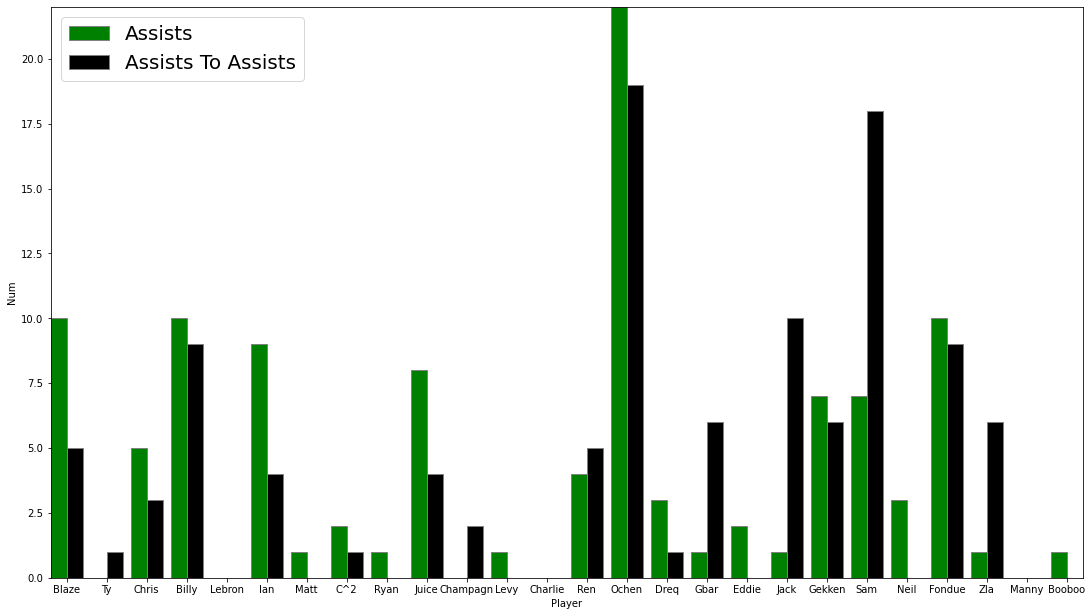

In [4]:

a = playersDF.loc[:,'assists']
aToA = playersDF.loc[:,'assistsToAssists']
width = 0.4
plt.bar(np.arange(len(a)), a, color='green', width=width, edgecolor='grey', label='Assists')
plt.bar(np.arange(len(aToA)) + width, aToA, color='black', width=width, edgecolor='grey', label='Assists To Assists')
plt.xlabel('Player')
plt.ylabel('Num')
plt.legend(loc=2, prop={'size': 20})
plt.xticks(np.arange(len(a)) + width/2, playersDF.index)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.margins(0)
plt.show()




#### Analysis of Assists v. Hockey Assists

The graph above compares assists to assists to assists (or better known as hockey assists). Hockey assists is not something *UltiAnalytics* explicity tracks which made curious to see which players were underated in their performace. Comparely to their assists, there is a significant amount of hockey assists in players like Zla, Sam, Jack, and Gbar. This info highlights a players ability to a set up the play to score. 